In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split,Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split

In [19]:
import torch.nn as nn
import torch.nn.functional as F

## Preparing Data

In [20]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
mnist_test = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [21]:
data = mnist_train.data.numpy().astype(np.float32) / 255.0
labels = mnist_train.targets.numpy()

In [22]:
data = data.reshape(data.shape[0], -1)
data_train, data_temp, labels_train, labels_temp = train_test_split(data, labels, test_size=0.4, random_state=42,
                                                                    stratify=labels)
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=0.5, random_state=42,stratify=labels_temp)

In [23]:
print("train:", data_train.shape, labels_train.shape)
print("val:", data_val.shape, labels_val.shape)
print("test:", data_test.shape, labels_test.shape)

train: (36000, 784) (36000,)
val: (12000, 784) (12000,)
test: (12000, 784) (12000,)


In [24]:
data_train_tensor = torch.tensor(data_train)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.long)

data_val_tensor = torch.tensor(data_val)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.long)

data_test_tensor = torch.tensor(data_test)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.long)

In [25]:
training_dataset = TensorDataset(data_train_tensor, labels_train_tensor)
validation_dataset = TensorDataset(data_val_tensor, labels_val_tensor)
testing_dataset = TensorDataset(data_test_tensor, labels_test_tensor)

In [26]:
training_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
testing_loader = DataLoader(testing_dataset, batch_size=64, shuffle=False)

In [27]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size=784, hidden1=256, hidden2=128, output_size=10):
        super(FeedforwardNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_size)
        
        # Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
model = FeedforwardNN(input_size=784, hidden1=256, hidden2=128, output_size=10).to(torch.device("cpu"))

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [29]:
def calculate_accuracy(model, dataloader):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(torch.device("cpu")), labels.to(torch.device("cpu"))
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [30]:
num_epochs = 50  
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    for inputs, labels in training_loader:
        inputs, labels = inputs.to(torch.device("cpu")), labels.to(torch.device("cpu"))
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_loss / len(training_loader.dataset)
    
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(torch.device("cpu")), labels.to(torch.device("cpu"))
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
    
    epoch_val_loss = val_running_loss / len(validation_loader.dataset)
    
    train_acc = calculate_accuracy(model, training_loader)
    val_acc = calculate_accuracy(model, validation_loader)
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch [1/50] Train Loss: 1.0360, Val Loss: 0.5129, Train Acc: 87.20%, Val Acc: 86.88%
Epoch [2/50] Train Loss: 0.4189, Val Loss: 0.3883, Train Acc: 89.69%, Val Acc: 89.62%
Epoch [3/50] Train Loss: 0.3404, Val Loss: 0.3347, Train Acc: 90.97%, Val Acc: 90.86%
Epoch [4/50] Train Loss: 0.3032, Val Loss: 0.3073, Train Acc: 91.83%, Val Acc: 91.46%
Epoch [5/50] Train Loss: 0.2771, Val Loss: 0.2879, Train Acc: 92.46%, Val Acc: 91.85%
Epoch [6/50] Train Loss: 0.2571, Val Loss: 0.2681, Train Acc: 93.07%, Val Acc: 92.58%
Epoch [7/50] Train Loss: 0.2407, Val Loss: 0.2532, Train Acc: 93.56%, Val Acc: 92.91%
Epoch [8/50] Train Loss: 0.2265, Val Loss: 0.2419, Train Acc: 93.89%, Val Acc: 93.12%
Epoch [9/50] Train Loss: 0.2137, Val Loss: 0.2293, Train Acc: 94.29%, Val Acc: 93.52%
Epoch [10/50] Train Loss: 0.2022, Val Loss: 0.2194, Train Acc: 94.53%, Val Acc: 93.77%
Epoch [11/50] Train Loss: 0.1925, Val Loss: 0.2114, Train Acc: 94.72%, Val Acc: 93.80%
Epoch [12/50] Train Loss: 0.1835, Val Loss: 0.2019, 

In [31]:
test_acc = calculate_accuracy(model, testing_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")


Final Test Accuracy: 96.78%


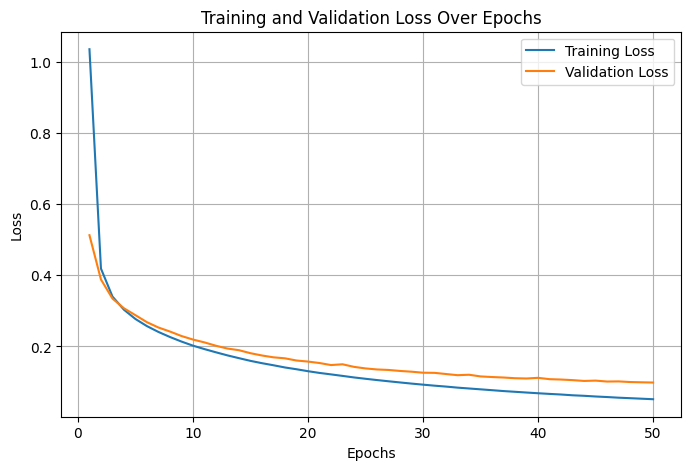

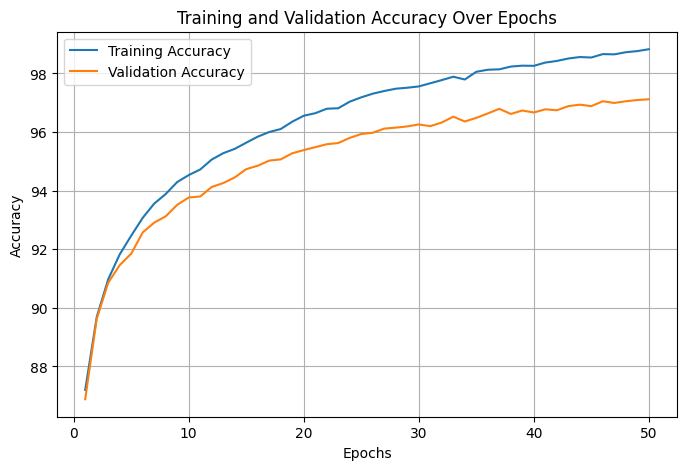

In [32]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

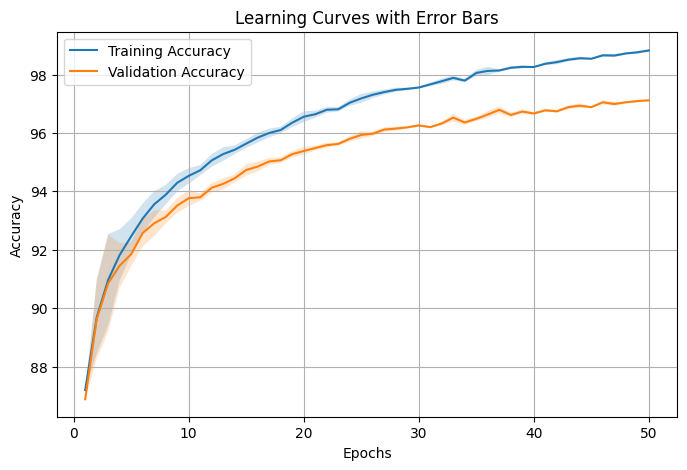

In [33]:
train_acc = np.array(train_accuracies)
val_acc = np.array(val_accuracies)

window = 2
train_std = np.array([np.std(train_acc[max(0,i-window):i+1]) for i in range(len(train_acc))])
val_std = np.array([np.std(val_acc[max(0,i-window):i+1]) for i in range(len(val_acc))])

plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.fill_between(epochs_range, train_acc-train_std, train_acc+train_std, alpha=0.2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.fill_between(epochs_range, val_acc-val_std, val_acc+val_std, alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves with Error Bars')
plt.legend()
plt.grid(True)
plt.show()

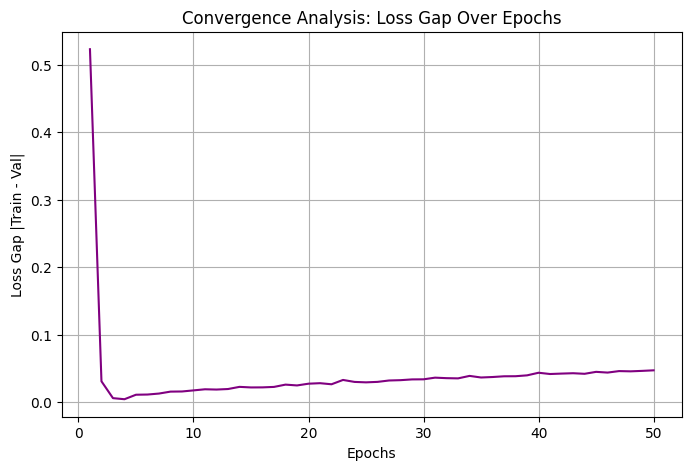

In [34]:
loss_gap = np.abs(np.array(train_losses) - np.array(val_losses))

plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss_gap, color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss Gap |Train - Val|')
plt.title('Convergence Analysis: Loss Gap Over Epochs')
plt.grid(True)
plt.show()